# Processing

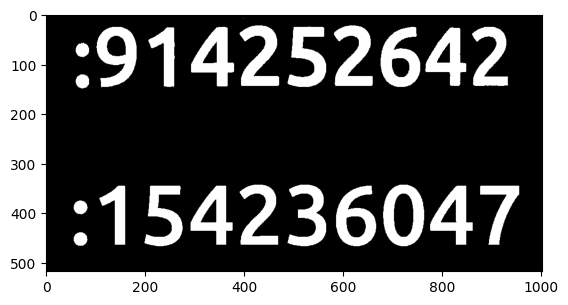

In [101]:
import cv2 as cv
import matplotlib.pyplot as plt


filename = 'extracted_images/rtsp_to_webrtc_4kcam_4k@30fps/img000001.png'

img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
_,img = cv.threshold(img, 60, 255, cv.THRESH_BINARY)

plt.imshow(img, 'gray')

In [102]:
import pytesseract
import re

custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
data = pytesseract.image_to_data(img, lang='eng', config=custom_config, nice=0, output_type=pytesseract.Output.DICT)
display(data)

matches = []
for i in range(len(data['text'])):
    text = data['text'][i]
    conf = float(data['conf'][i]) / 100
    matched = re.findall(r'\d{9}(?=[\s:]|$)', text)
    for match in matched:
        matches.append((conf, int(match)))

matches

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2],
 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1],
 'left': [0, 60, 60, 60, 60, 56, 56, 56, 56],
 'top': [0, 23, 23, 23, 23, 344, 344, 344, 344],
 'width': [1002, 874, 874, 874, 874, 900, 900, 900, 900],
 'height': [518, 127, 127, 127, 127, 124, 124, 124, 124],
 'conf': [-1, -1, -1, -1, 89, -1, -1, -1, 90],
 'text': ['', '', '', '', ':914252642', '', '', '', ':154236047']}

[(0.89, 914252642), (0.9, 154236047)]

In [103]:
import cv2 as cv
import pytesseract
import glob
import re
import multiprocessing
import psutil
from tqdm import tqdm
from typing import List, Tuple

def extract_numbers(filename: str) -> List[Tuple[float, int]]:
    try:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        _, img = cv.threshold(img, 60, 255, cv.THRESH_BINARY)

        # https://ai-facets.org/tesseract-ocr-best-practices/
        custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
        # custom_config = r'--oem 1 --psm 12'
        data = pytesseract.image_to_data(img, lang='eng', config=custom_config, output_type=pytesseract.Output.DICT)

        matches = []
        for i in range(len(data['text'])):
            text = data['text'][i]
            conf = float(data['conf'][i]) / 100
            matched = re.findall(r'\d{9}(?=[\s:]|$)', text)
            for match in matched:
                matches.append((conf, int(match)))

        return matches

    except (cv.error, pytesseract.TesseractError, ValueError):
        return []


def extract_numbers_parallel(pattern: str) -> List[Tuple[str, List[Tuple[float,int]]]]:
    files = glob.glob(pattern)

    # Get the number of CPUs and available memory
    num_cpus = psutil.cpu_count(logical=False)
    mem_stats = psutil.virtual_memory()
    mem_avail = mem_stats.available / (1024 * 1024 * 1024)

    # Limit the number of processes based on the available resources
    max_processes = min(num_cpus, int(mem_avail * 1.5), 15)
    num_processes = max(1, max_processes)

    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap_unordered(extract_numbers, files), total=len(files)))

    return list(zip(files, results))

numbers = extract_numbers_parallel('extracted_images/rtsp_to_webrtc_4kcam_4k@30fps/img*.png')

100%|██████████| 3786/3786 [02:25<00:00, 25.94it/s]


In [109]:
import pandas as pd
import numpy as np

def numbers_to_dataframe(numbers: List[Tuple[str, List[Tuple[float, int]]]]) -> pd.DataFrame:
    data = []
    for filename, num_list in numbers:
        if len(num_list) == 2:
            data.append({
                'filename': filename,
                '0_confidence': num_list[0][0],
                '1_confidence': num_list[1][0],
                '0_value': num_list[0][1],
                '1_value': num_list[1][1],
            })

    return pd.DataFrame(data)

df = numbers_to_dataframe(numbers)

df = df.rename(columns={
    '0_confidence': 'time_rtsp_to_webrtc_confidence',
    '1_confidence': 'time_host_confidence',
    '0_value': 'time_rtsp_to_webrtc',
    '1_value': 'time_host',
})
df = df.set_index('filename', drop=True).sort_index().reset_index(drop=True)

# Scale to milliseconds (from an 9-digits number after the seconds comma)
df['time_host'] = df['time_host'] * 1e-6
df['time_rtsp_to_webrtc'] = df['time_rtsp_to_webrtc'] * 1e-6

# Compute latencies - because time is warping each second, we get the absolute values
df['delay_rtsp_to_webrtc'] = np.abs(df['time_host'] - df['time_rtsp_to_webrtc'])

# Computed jitter
df['jitter_rtsp_to_webrtc'] = np.abs(df['delay_rtsp_to_webrtc'].mean() - df['delay_rtsp_to_webrtc'])

df.describe()


,time_rtsp_to_webrtc_confidence,time_host_confidence,time_rtsp_to_webrtc,time_host,delay_rtsp_to_webrtc,jitter_rtsp_to_webrtc
count,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000,3708.000000
mean,0.842379,0.897395,512.391317,499.701433,367.635307,195.455064
std,0.090480,0.007242,289.613900,288.864124,228.152949,117.646848
min,0.440000,0.870000,2.344615,2.192358,106.376081,10.980826
25%,0.810000,0.890000,262.478835,250.282726,240.217913,120.750673
50%,0.890000,0.900000,514.426503,502.446241,246.548570,127.367843
75%,0.900000,0.900000,762.631625,754.242851,323.912199,225.537203
max,0.920000,0.920000,998.965663,998.681584,860.091680,492.456373


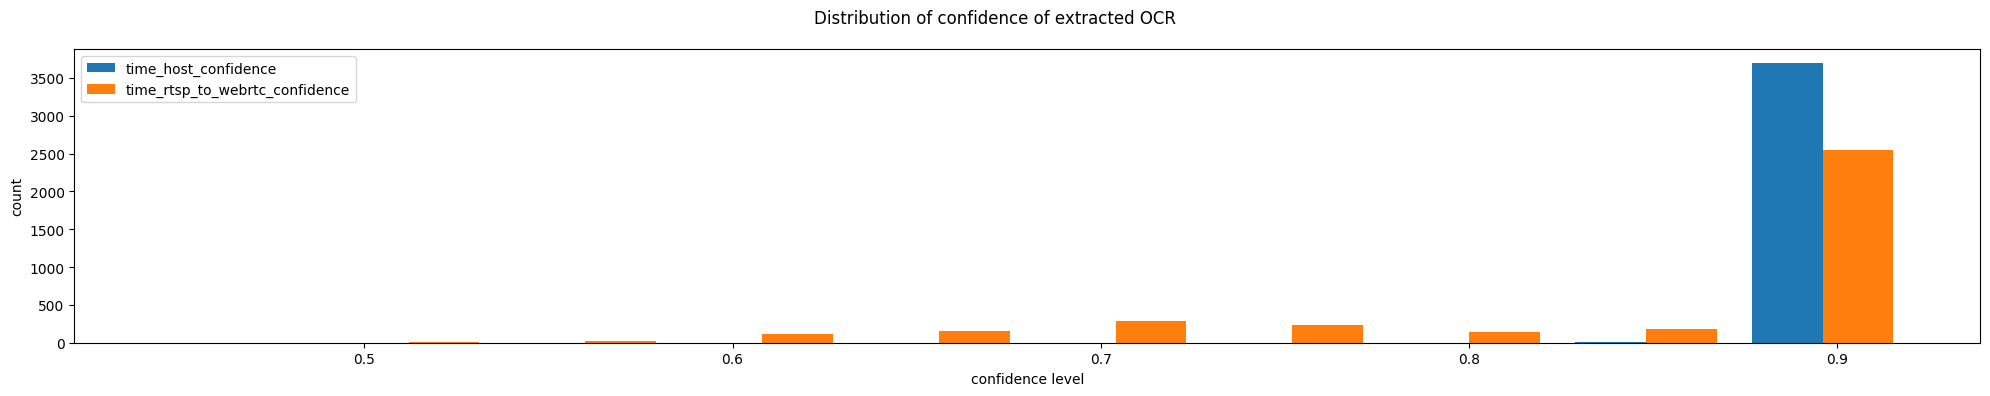

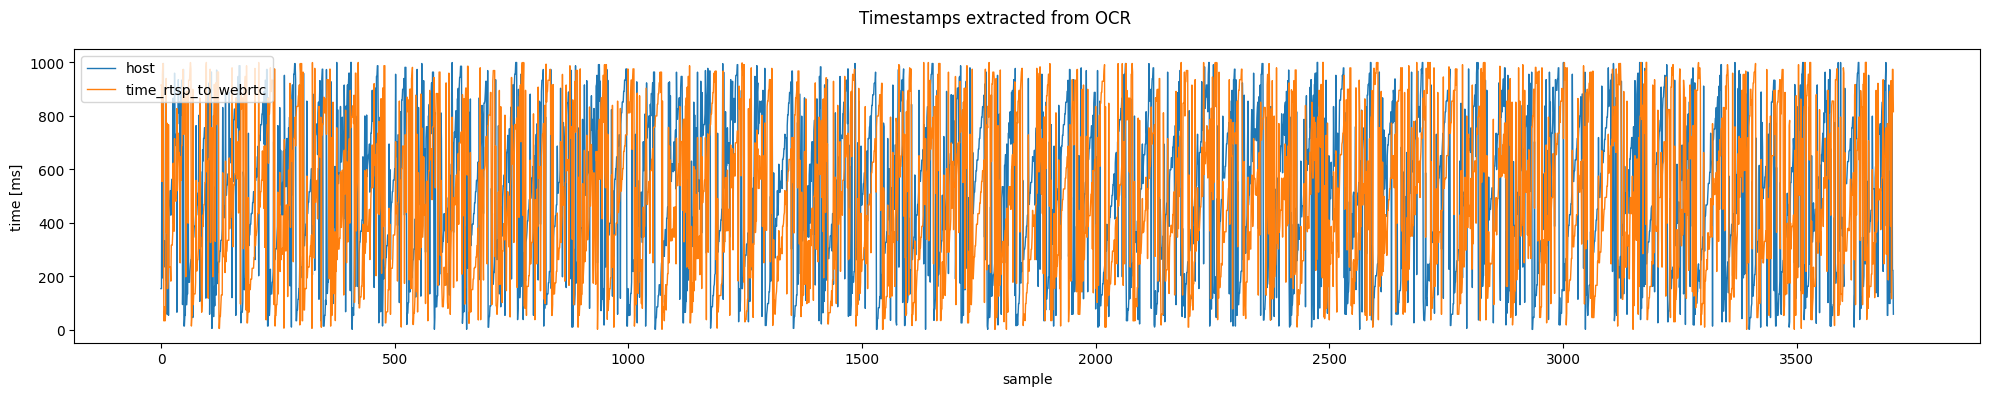

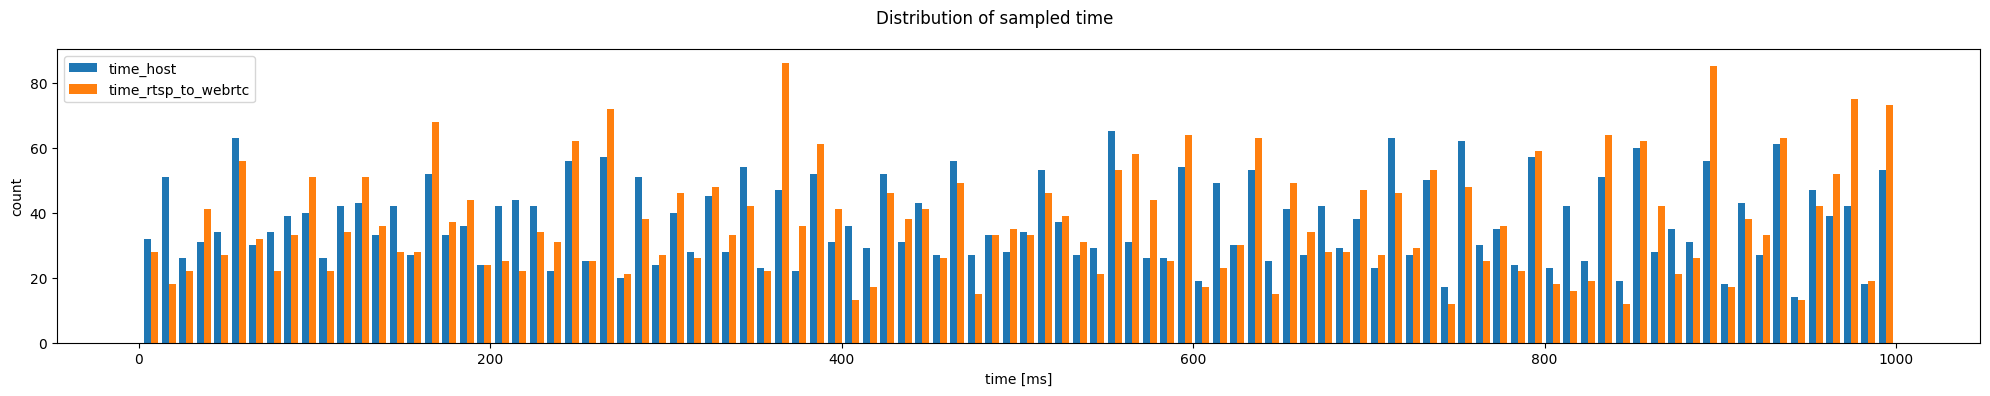

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_rtsp_to_webrtc_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_rtsp_to_webrtc'], label='time_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [112]:
# Filter out low-confidence values
confidence_threshold = 0.87

print(f'Length before filtering out values with confidence lower than {confidence_threshold}:', len(df))
df = df[df['time_host_confidence'] >= confidence_threshold]
df = df[df['time_rtsp_to_webrtc_confidence'] >= confidence_threshold]
print(f'Length after filtering out values with confidence lower than {confidence_threshold}:', len(df))

df.describe()

Length before filtering out values with confidence lower than 0.87: 2600
Length after filtering out values with confidence lower than 0.87: 2600


,time_rtsp_to_webrtc_confidence,time_host_confidence,time_rtsp_to_webrtc,time_host,delay_rtsp_to_webrtc,jitter_rtsp_to_webrtc
count,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000
mean,0.894427,0.897381,506.761010,505.818529,364.995051,191.264451
std,0.009340,0.007251,288.250423,287.637396,222.985300,114.600401
min,0.870000,0.870000,2.344615,2.192358,199.116288,71.205474
25%,0.890000,0.890000,262.249099,254.712277,241.817925,121.104574
50%,0.890000,0.900000,512.284036,510.666683,246.219557,125.609103
75%,0.900000,0.900000,754.674726,754.787119,288.281559,167.651311
max,0.920000,0.920000,998.681584,998.681584,800.331787,432.696480


In [113]:
# Filter out outliers
from scipy import stats

# Compute Z-score for each column
z = np.abs(stats.zscore(df))

# Define threshold for outlier detection
z_score_threshold = 1.5

print(f'Length before filtering by z-score of {z_score_threshold}:', len(df))

# Filter out rows with any values above threshold
df = df[(z < z_score_threshold).all(axis=1)]

print(f'Length after filtering by z-score of {z_score_threshold}:', len(df))

df.reset_index(drop=True)

df.describe()

Length before filtering by z-score of 1.5: 2600
Length after filtering by z-score of 1.5: 1027


,time_rtsp_to_webrtc_confidence,time_host_confidence,time_rtsp_to_webrtc,time_host,delay_rtsp_to_webrtc,jitter_rtsp_to_webrtc
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000
mean,0.894849,0.896602,394.742139,635.178504,240.436365,127.198943
std,0.005000,0.004739,184.604334,184.162419,20.888258,20.888258
min,0.890000,0.890000,74.602546,294.561766,199.116288,71.747698
25%,0.890000,0.890000,234.694366,471.741606,239.933304,119.514390
50%,0.890000,0.900000,394.734944,642.301717,244.050455,123.584852
75%,0.900000,0.900000,552.458949,796.387948,248.120917,127.702003
max,0.900000,0.900000,734.526654,936.697125,295.887609,168.519019


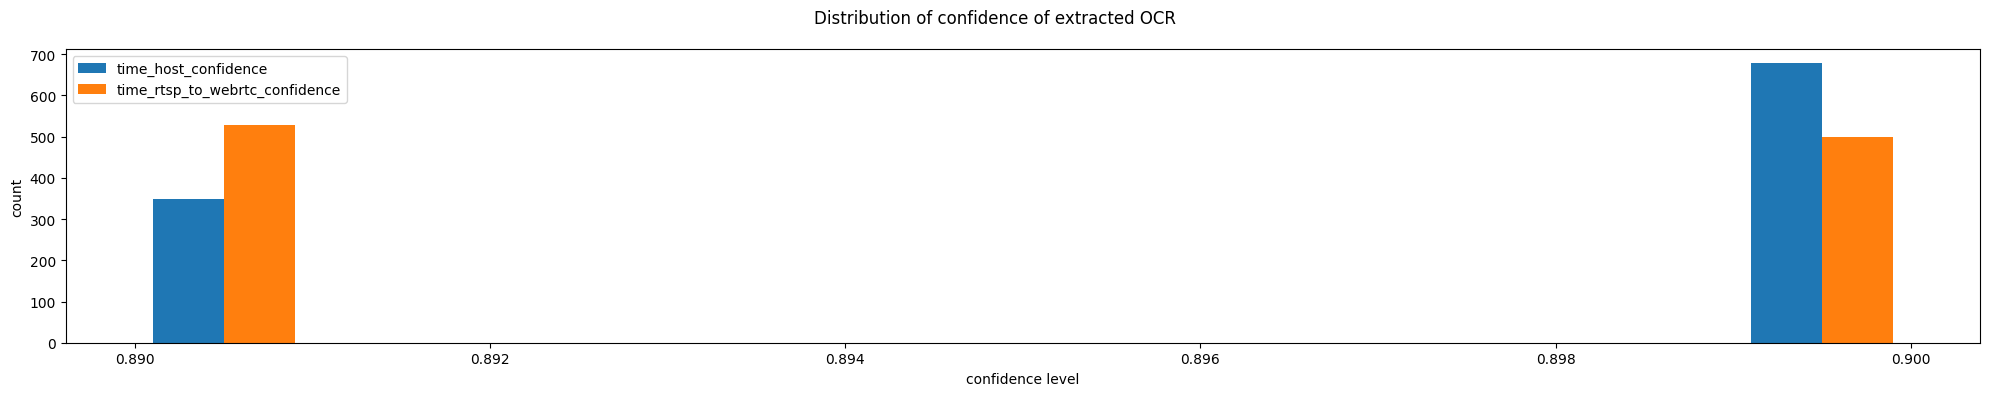

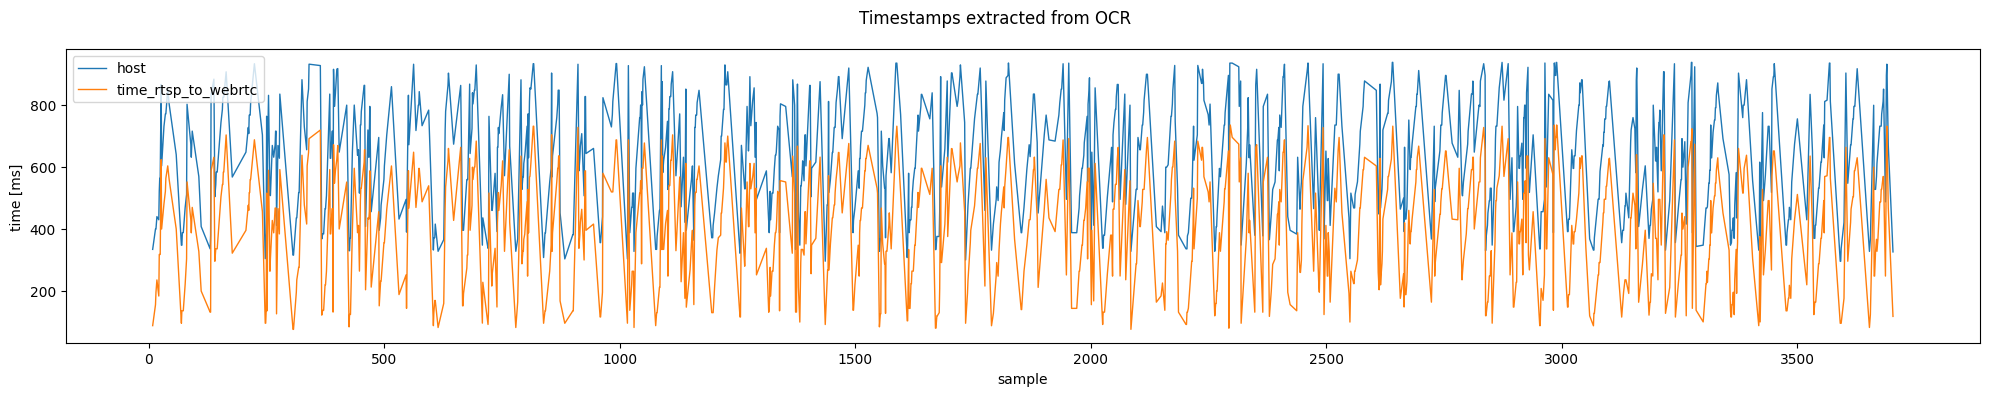

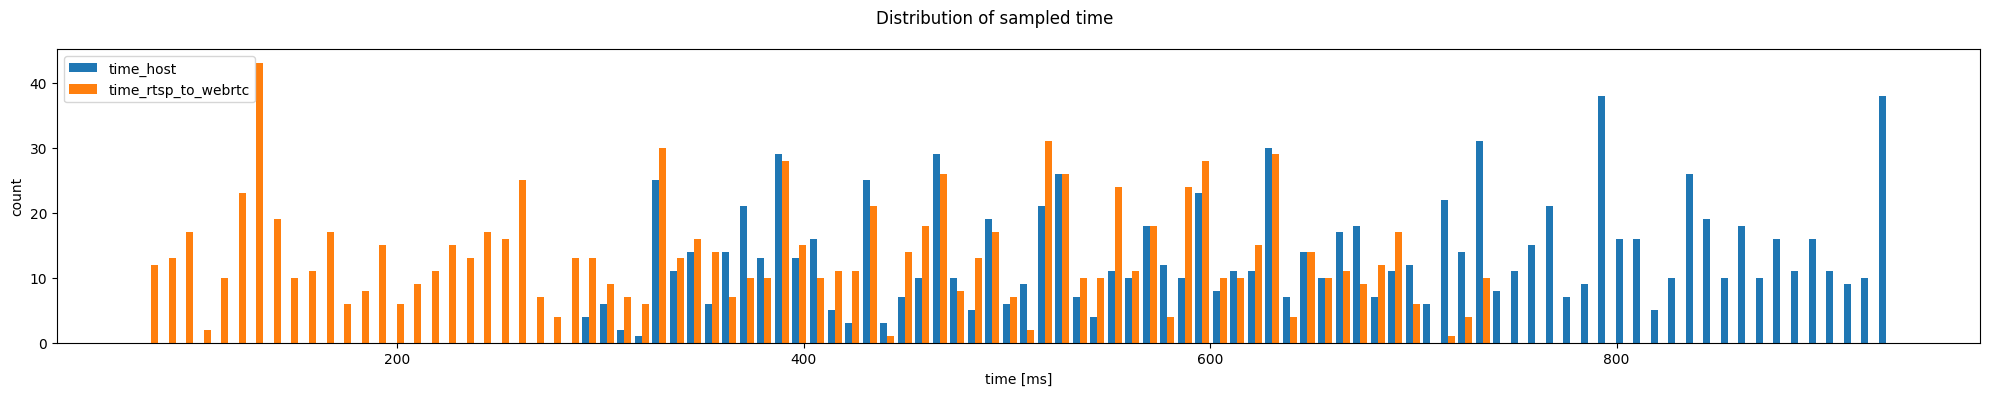

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_rtsp_to_webrtc_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_rtsp_to_webrtc'], label='time_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

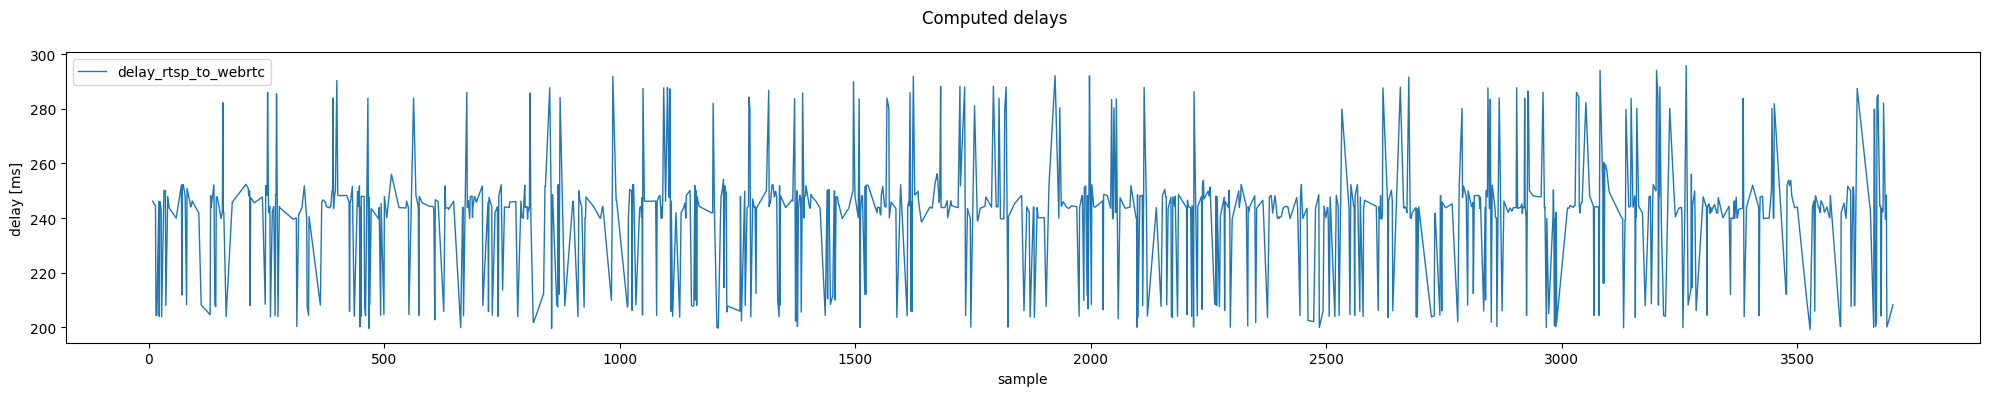

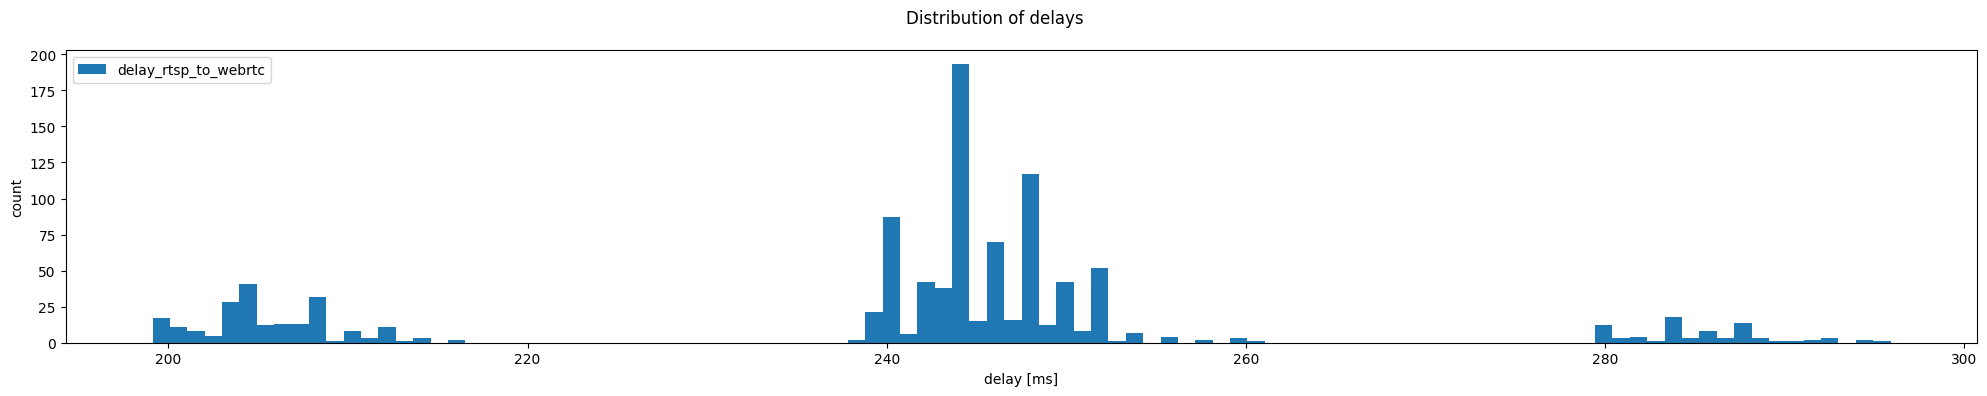

In [115]:
plt.figure(figsize=(20,4))

plt.suptitle('Computed delays')
plt.xlabel('sample')
plt.ylabel('delay [ms]')

plt.plot(df.index, df['delay_rtsp_to_webrtc'], label='delay_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of delays')
plt.xlabel('delay [ms]')
plt.ylabel('count')

cols = ['delay_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


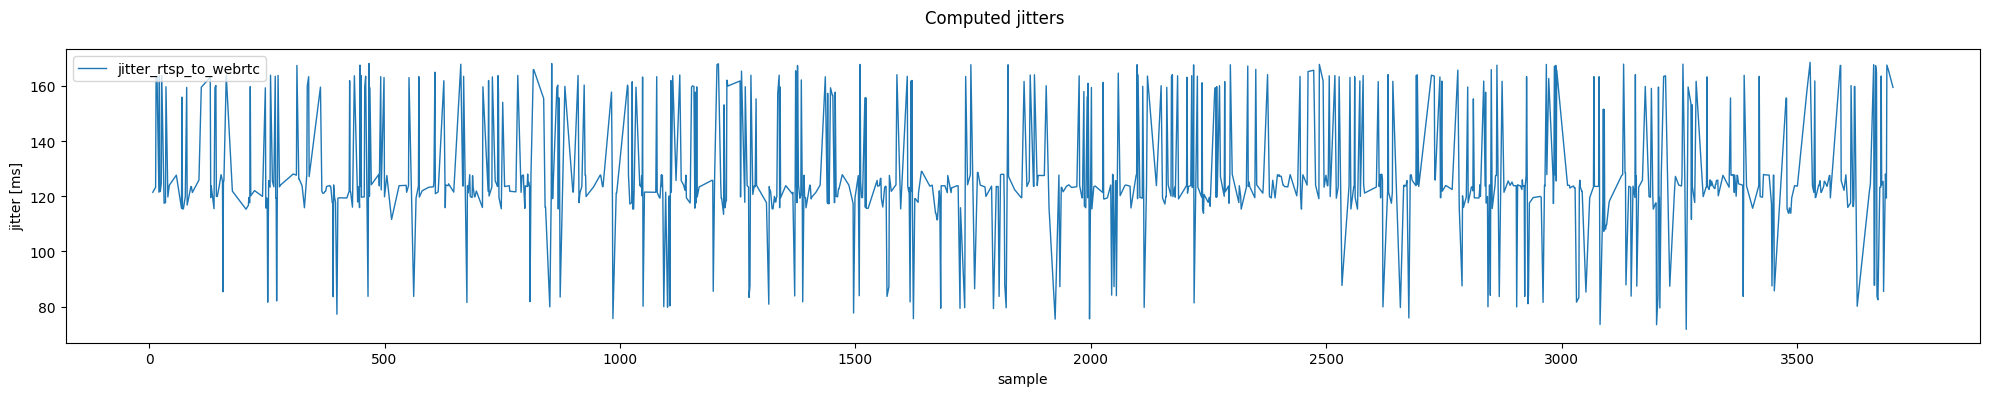

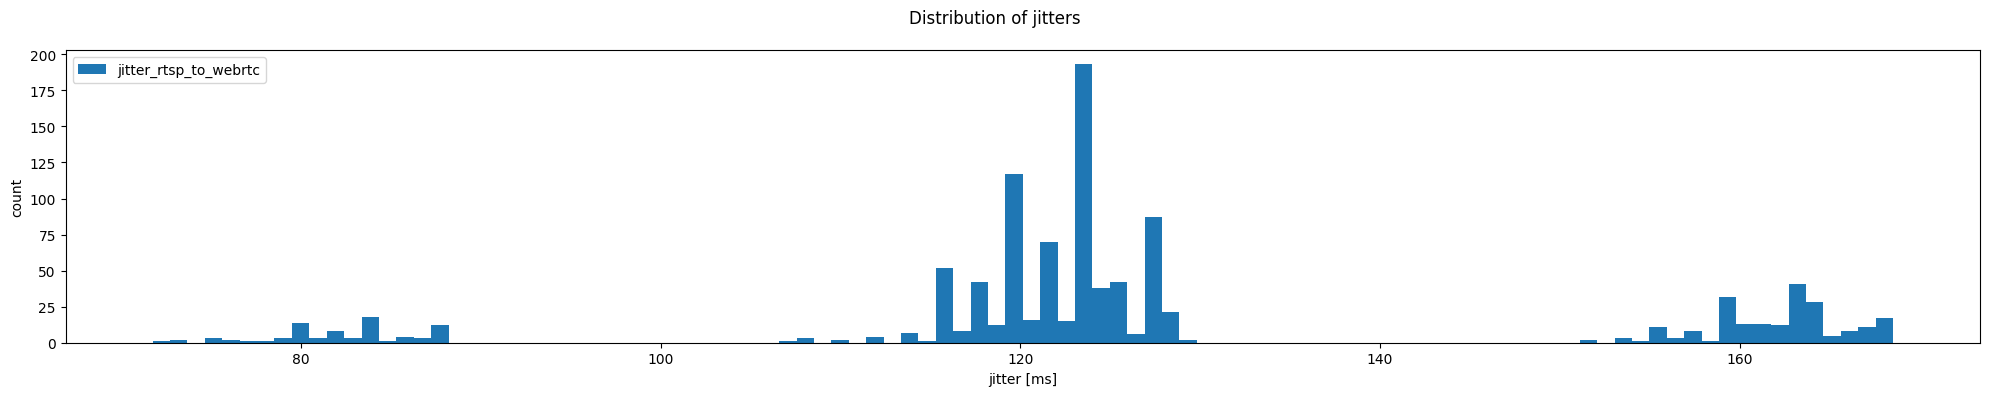

In [116]:
plt.figure(figsize=(20,4))

plt.suptitle('Computed jitters')
plt.xlabel('sample')
plt.ylabel('jitter [ms]')

plt.plot(df.index, df['jitter_rtsp_to_webrtc'], label='jitter_rtsp_to_webrtc', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of jitters')
plt.xlabel('jitter [ms]')
plt.ylabel('count')

cols = ['jitter_rtsp_to_webrtc']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
